# TfL Lump

A cursory exploration of the Transport for London system and its open data API.

The package implements a modest wrapper around a very small portion of the [TfL open data](https://tfl.gov.uk/info-for/open-data-users/) API facilitating fetching of core public transport modes ('bus', 'tube', 'overground', etc). For analysis purposes fetched data is cached to local files. Store objects make the data available as Pandas dataframes and enable writing out as JSON.

As a view into a large scale, highly managed, operational system the TfL open data is formatted for targeted queries rather than static analysis. For the purposes of this cursory analysis project only a small subset of the Mode, Line, and StopPoint APIs have been implemented in the package. Response data has been mapped to more modest dictionaries using Pydantic models for validation and organization. Two primary Store classes provide file cached data backed by rate-limited fetching from the API. 

- The `LineStore` class handles data for a single TfL Mode and gives access to the Lines of that mode as well as each Line's available routes. 

- The `StopPointStore` class indexes individual StopPoints which may be shared across routes. 

<sub>Powered by TfL Open Data. Contains OS data © Crown copyright and database rights 2016 and Geomni UK Map data © and database rights [2019]</sub>

![alt text](./images/Screenshot%202024-07-13%20at%2000.22.41.png "Title")

In [3]:
"""Imports and global configuration."""
from __future__ import annotations

import itertools
import json
import warnings

import folium
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import seaborn as sns
import shapely
from shapely.geometry import LineString, Point

# tflump
from tflump import Direction, LineStore

warnings.filterwarnings("ignore")

# matplotlib
plt.rcParams["figure.dpi"] = 512

# seaborn
sns.set_style("ticks", {"axes.grid": False})

# colors
superloop_palette = ["#57575A", "#273890", "#2094A2", "#EF4322"]
direction_palette = {
    Direction.INBOUND: ["#EF4423", "#F7941C"],
    Direction.OUTBOUND: ["#283991", "#2094A2"],
}

In [94]:
"""Load LineStore for mode `bus` and retrieve dataframe."""

bus_store = LineStore(mode="bus")
bus_store.load()

bus_df = bus_store.dataframe()

# Count route sections per line
bus_df["route_count"] = bus_df["route_sections"].map(len)


bus_df.head(3)

,id,name,mode_name,route_sections,service_types,route_count
0,1,1,bus,[{'name': 'Royal Free Hospital - Canada Water ...,[Regular],2
1,100,100,bus,[{'name': 'King Edward Street / St Pauls Stati...,[Regular],2
2,101,101,bus,[{'name': 'Woodbine Place - Beckton Bus Statio...,[Regular],2


In [95]:
"""Retrieve the stop point dataframe from the LineStore."""

stoppoint_df = bus_store.stoppoint_store().dataframe()

stoppoint_df.head(3)

,id,stop_letter,name,lat,lon,lines,modes,parent_id,station_id,top_most_parent_id
0,490011760D,D,Royal Free Hospital,51.553947,-0.165511,"[1, 46, c11]",[bus],490G000732,490G000732,490G000732
1,490011714E,E,Rosslyn Hill,51.553441,-0.168286,"[1, 46, c11]",[bus],490G00011714,490G00011714,490G00011714
2,490015255F,F,Haverstock Hill / Pond Street,51.552266,-0.167295,"[1, 268, c11, n5]",[bus],490G00015255,490G00015255,490G00015255


## Overview

In [96]:
"""Utility functions for expanding nested columns."""


def dict_to_series(dct: dict, pre: str) -> pd.Series:
    """Convert a encoded dict to a Series."""
    keys, values = zip(*list(dct.items()))

    return pd.Series(values, index=[f"{pre}{k}" for k in keys])


def explode_dict(
    row: pd.Series,
    col: str,
    pre: str = "",
    drop_row: bool = False,
) -> pd.Series:
    """Expand dict column to individual columns by keys."""
    dict_series = dict_to_series(row[col], pre)

    concat_row = pd.concat([row, dict_series])

    if drop_row:
        concat_row = concat_row.drop(labels=[col])

    return concat_row

### Lines 

At the time of fetching Transport for London was operating **677** bus lines serving **19,974** individual stop points. 

The majority of bus lines have 2 individual routes: an outbound journey and an inbound journey covering the same corridor as road/traffic constraints allow.

Exceptions to this are:

- Routes flagged as *outbound only*, which travel in one direction only (ie. 628 — Jewish Free School - Southgate Station).  
These are all marked as having an *outbound* direction.

- Routes with multiple origination points or cyclic service. 

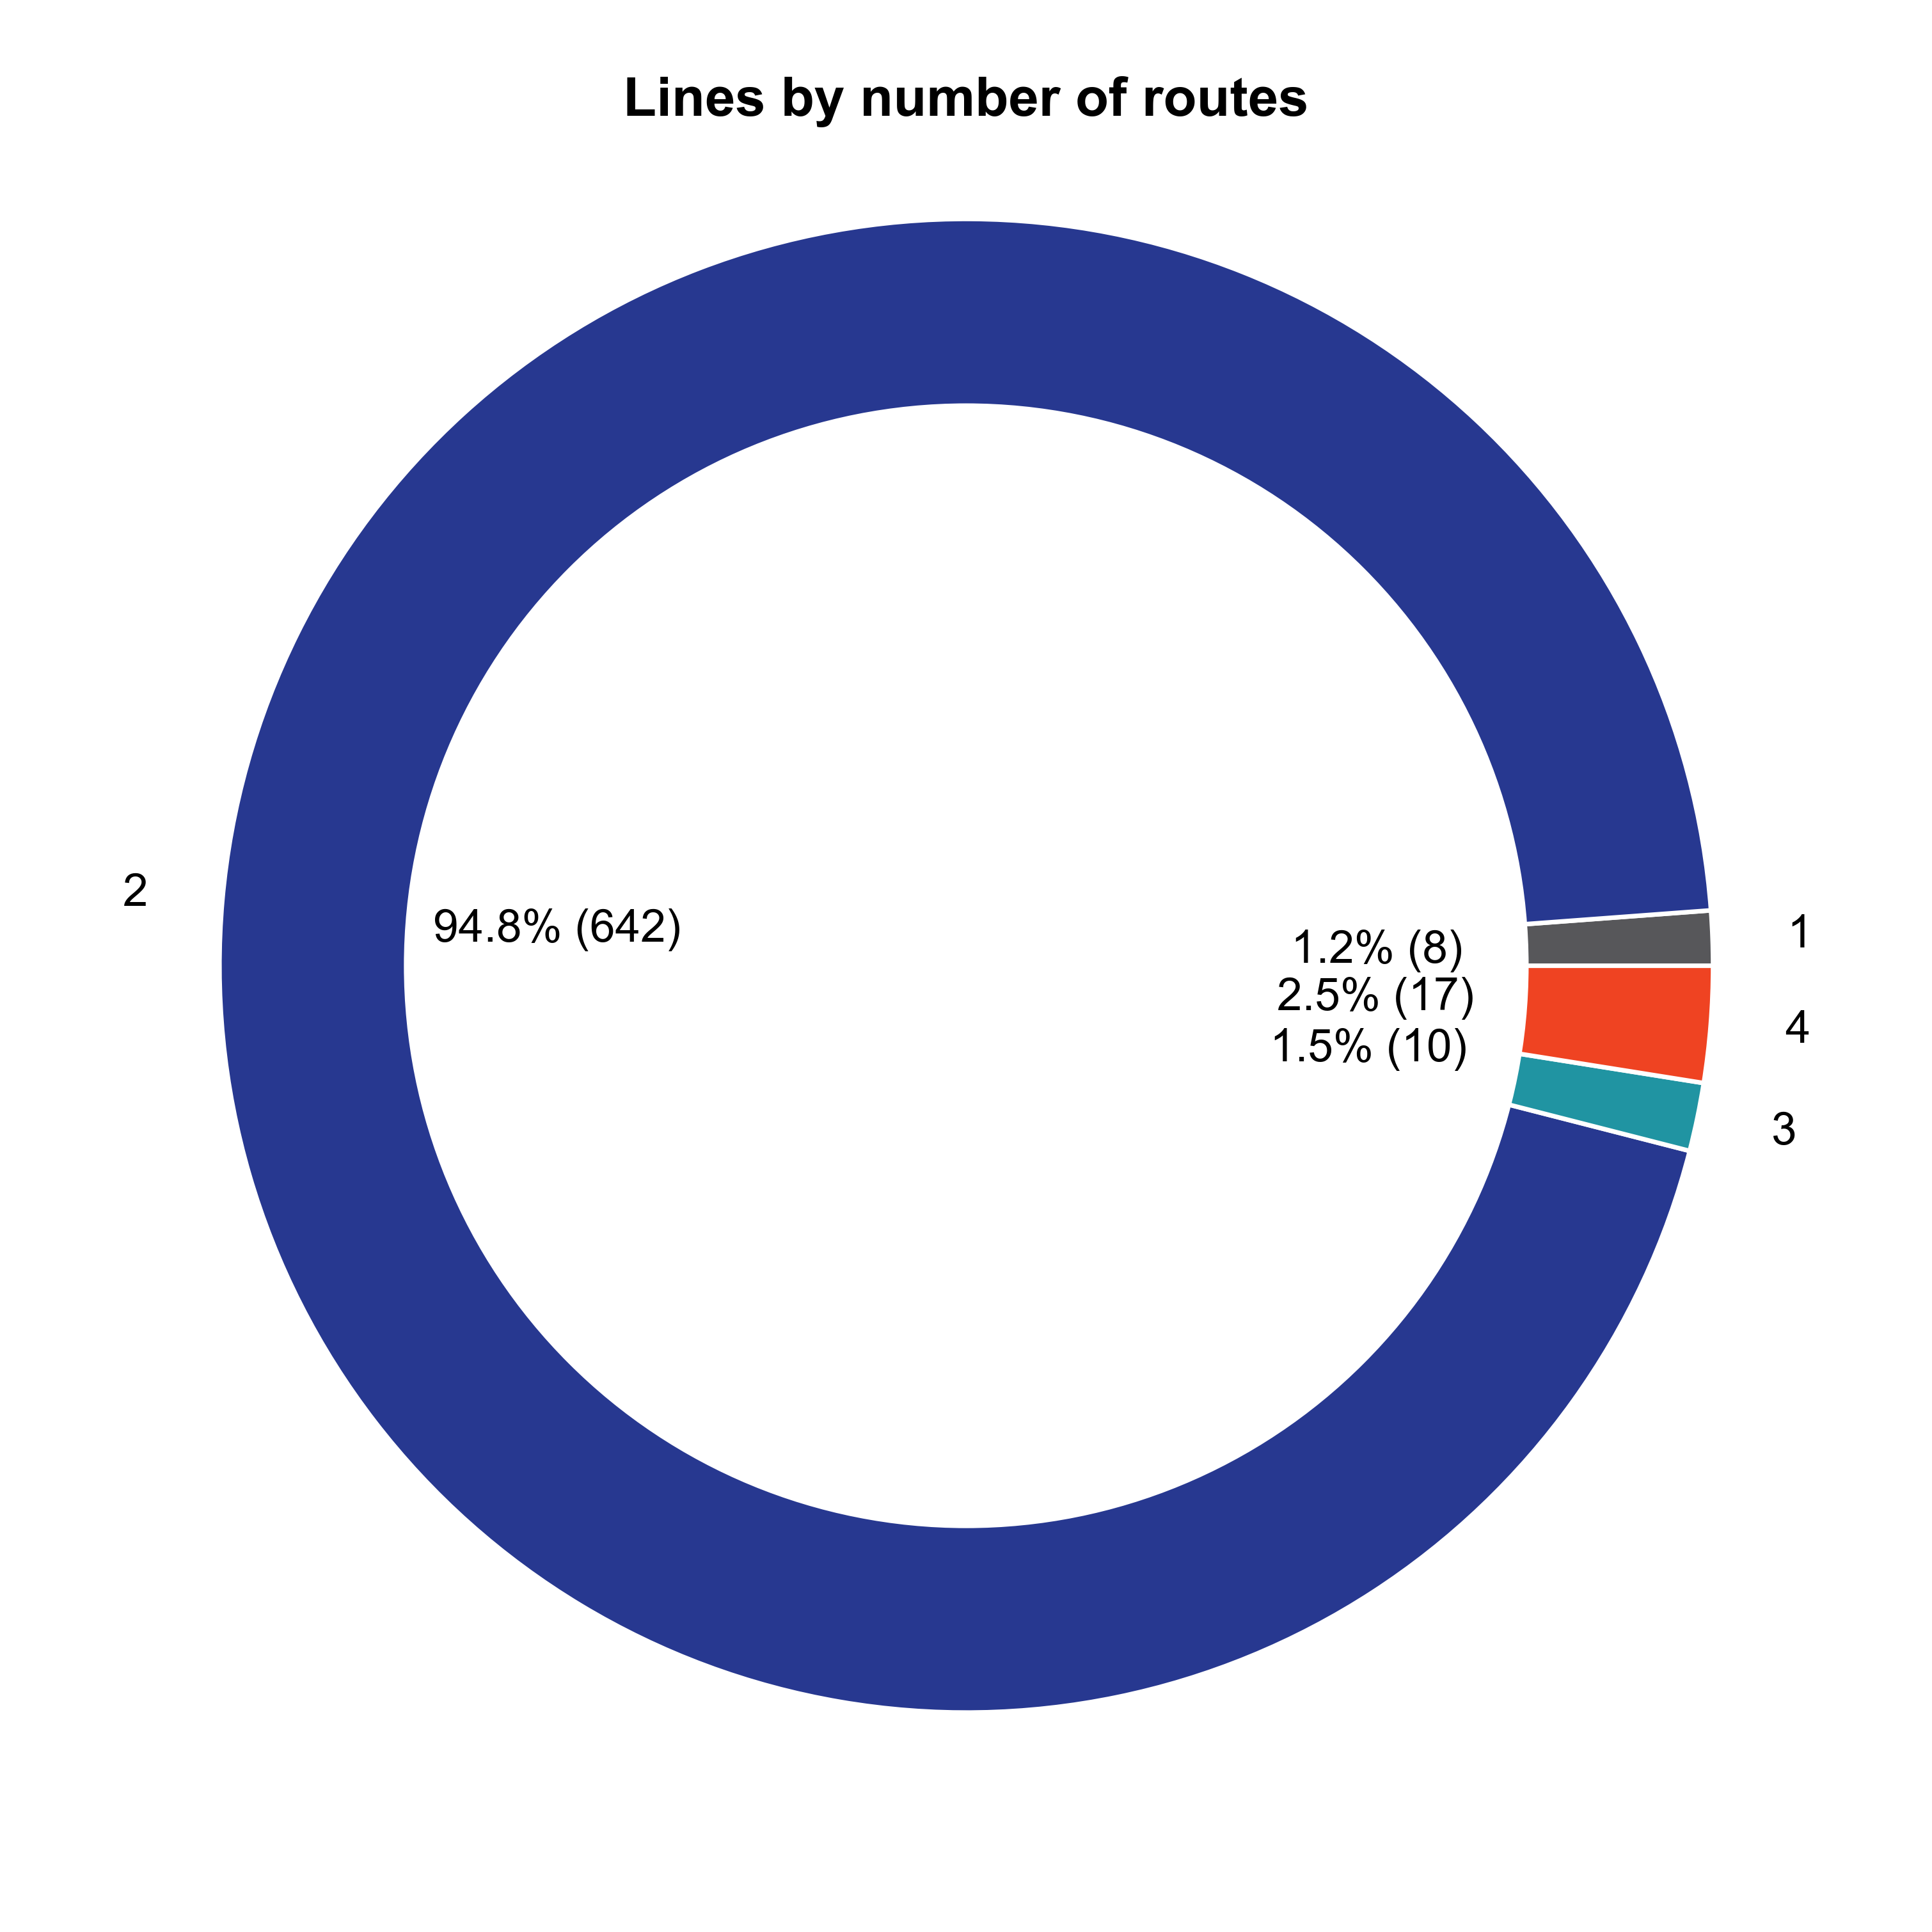

In [97]:
"""Overview of line and route counts. (Bus lines: 677 — Stop points: 19974)"""

# print(f"  Bus lines: {len(bus_df)} — Stop points: {len(stoppoint_df)}")

# print(bus_df["route_count"].value_counts())


# plot lines by number of route sections.
data = bus_df.groupby("route_count").size().fillna(0).sort_index()

fig, ax = plt.subplots(1, 1, figsize=(6, 6), facecolor="white")

ax.pie(
    data,
    labels=data.index,
    autopct=lambda x: f"{x:.1f}% ({sum(data) * x / 100:.0f})",
    pctdistance=0.55,
    colors=superloop_palette,
    textprops={"color": "black"},
)
fig.text(
    0.5,
    0.94,
    "Lines by number of routes",
    color="black",
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=12,
    fontweight="bold",
    fontfamily="sans-serif",
)

centre_circle = plt.Circle((0, 0), 0.75, fc="white")

fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
# ax.axis('equal')
plt.tight_layout()
plt.show();

### Stops

If we expand the line data by their route sections we can look a look for trends in line design by TfL. 

As a starting point we can look at: 
 
- The number of stop points each line serves

- The congruency of *inbound* and *outbound* routes in terms of path and stop points

- The length of routes both overall and between stop points

- The orientation of routes 

In [98]:
"""Utility functions for geo analysis"""


def parse_linestrings(
    linestrings: list[str],
    reverse: bool = True,
) -> list[list[tuple[float, float]]]:
    """Parse a nested JSON linestring array and reverse coordinate order.

    Parameters:
    linestrings : list[str]
        A list containing encoded JSON strings

    reverse : bool = True
        If `True` reverses the coordinate order.

    Note:
    TfL encodes linestrings as `[lon, lat]` pairs but folium expects `[lat, lon]`.
    """
    parsed = next(map(json.loads, linestrings))
    if reverse:
        return [[[lat, lon] for lon, lat in line] for line in parsed]

    return parsed

In [99]:
"""Distance utilities for LineStrings"""

osgb36 = pyproj.Proj(init="epsg:27700")
wgs84 = pyproj.Proj(init="epsg:4326")
epsg3035 = pyproj.Proj(init="epsg:3035")


def linestring_distance(linestrings: list[list[tuple[float, float]]]) -> float:
    return sum(
        [
            pyproj.Geod(ellps="WGS84").geometry_length(
                LineString(map(Point, linestring)),
            )
            for linestring in linestrings
        ],
    )


def mean_route_distance(
    line_id: str,
    directions: [Direction] = None,
):
    """Calculate mean distance of routes for passed directions."""
    if directions is None:
        directions = [Direction.INBOUND, Direction.OUTBOUND]

    bus_line = (
        bus_routes_df.loc[
            (bus_routes_df["id"] == line_id)
            & (bus_routes_df["route_direction"].isin(directions)),
        ]
        .copy()
        .reset_index()
    )

    # Filter bus routes by line_id and direction
    line_routes = bus_line[["route_direction", "route_line_strings"]]

    # Parse JSON encoded line_strings
    # NOTE: Don't reveres coordinate order `[lon, lat]` is correct for here.
    distances = line_routes["route_line_strings"].apply(
        lambda c: linestring_distance(
            parse_linestrings(
                linestrings=c,
                reverse=False,
            )
        ),
    )

    # distances = line_routes["route_line_strings"].apply(linestring_distance)

    return distances.mean()

In [100]:
"""Expand bus lines by `route_sections`."""


bus_routes_df = (
    bus_df.explode("route_sections")
    .reset_index(drop=True)
    .copy()
    .apply(
        lambda r: explode_dict(r, "route_sections", "route_", drop_row=True),
        axis=1,
    )
)

# Calculate the distance of each route
bus_routes_df["route_distance"] = bus_routes_df["route_line_strings"].apply(
    lambda c: linestring_distance(
        parse_linestrings(
            linestrings=c,
            reverse=False,
        ),
    ),
)

# Count of stop points per route
bus_routes_df["route_stop_count"] = bus_routes_df["route_ordered_line_routes"].apply(
    lambda c: sum(len(x) for x in c)
)

bus_routes_df.head(3)

,id,name,mode_name,service_types,route_count,route_name,route_direction,route_origination_name,route_destination_name,route_originator,route_destination,route_service_type,route_valid_to,route_valid_from,route_is_outbound_only,route_line_strings,route_ordered_line_routes,route_distance,route_stop_count
0,1,1,bus,[Regular],2,Royal Free Hospital - Canada Water Bus Station,outbound,Royal Free Hospital,Canada Water Bus Station,490011760D,490004733D,Regular,2024-12-23 00:00:00+00:00,2024-07-06 00:00:00+00:00,False,"[[[[-0.165413,51.554097],[-0.165797,51.554005]...","[[490011760D, 490011714E, 490015255F, 49000002...",14552.627448,48
1,1,1,bus,[Regular],2,Canada Water Bus Station - South End Green,inbound,Canada Water Bus Station,South End Green,490004733C,490012280N,Regular,2024-12-23 00:00:00+00:00,2024-07-06 00:00:00+00:00,False,"[[[[-0.049903,51.497756],[-0.049621,51.4976],[...","[[490004733C, 490011723E, 490013042J, 49000022...",14435.786421,43
2,100,100,bus,[Regular],2,King Edward Street / St Pauls Station - St Geo...,outbound,King Edward Street / St Pauls Station,St George's Town Hall / Shadwell Stn,490008743N,490012020A,Regular,2024-12-23 00:00:00+00:00,2024-07-06 00:00:00+00:00,False,"[[[[-0.098569,51.516554],[-0.098571,51.516785]...","[[490008743N, 49008743N1, 490010130N, 49000381...",13782.374338,26


### Distance

London is a sprawling city measuring 40 kilometres North to South and 58 kilometres East to West. The bus system criss-crosses this area with routes averaging just **14.86 km** in length. The longest route is **74.96 km** and the shortest a mere **1.6 km**.


![The longest and shortest bus lines in London.](./images/longest_shortest_map.png "Title")

In [1]:
"""Longest and shortest routes."""

max_distance = bus_routes_df["route_distance"].max()
min_distance = bus_routes_df["route_distance"].min()

longest_route = bus_routes_df[bus_routes_df["route_distance"] == max_distance].iloc[0]
shortest_route = bus_routes_df[bus_routes_df["route_distance"] == min_distance].iloc[0]

print(f"Longest route: {longest_route['name']} - {longest_route['route_name']}")
print(f"Shortest route: {shortest_route['name']} - {shortest_route['route_name']}")

# bus_routes_df["route_distance"].describe()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/nymph/Documents/cambridge-spark/portfolio/rye/lump-cs/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/var/folders/94/v34vyqln40xg6t5w10210mg40000gn/T/ipykernel_38535/3112108121.py", line 3, in <module>
    max_distance = bus_routes_df["route_distance"].max()
                   ^^^^^^^^^^^^^
NameError: name 'bus_routes_df' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/nymph/Documents/cambridge-spark/portfolio/rye/lump-cs/.venv/lib/python3.12/site-packages/pygments/styles/__init__.py", line 45, in get_style_by_name
ModuleNotFoundError: No module named 'pygments.styles.default'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/nymph/Documents/cambridge-spark/portfolio/rye/lump-cs/.venv/lib/python3.12/site-packages/IPython/core/int

#### Distance distribution

The distribution of routes by total distance shows a strong positive skew with the mean falling at 14km. Within the interquartile range the distribution is quite symmetrical, but just beyond the upper threshold we see a slight second peak between 30km and 40km. there are consistent outliers on the longer end of the distribution.

This distribution largely makes sense given the shape of the city. A large urban center with significant built up secondary zones points to the necessity for many medium distance transport options. As the city continues to sprawl travel distances both to the center of the city and around it perimeter would speak to the outliers on the higher end of the distribution.

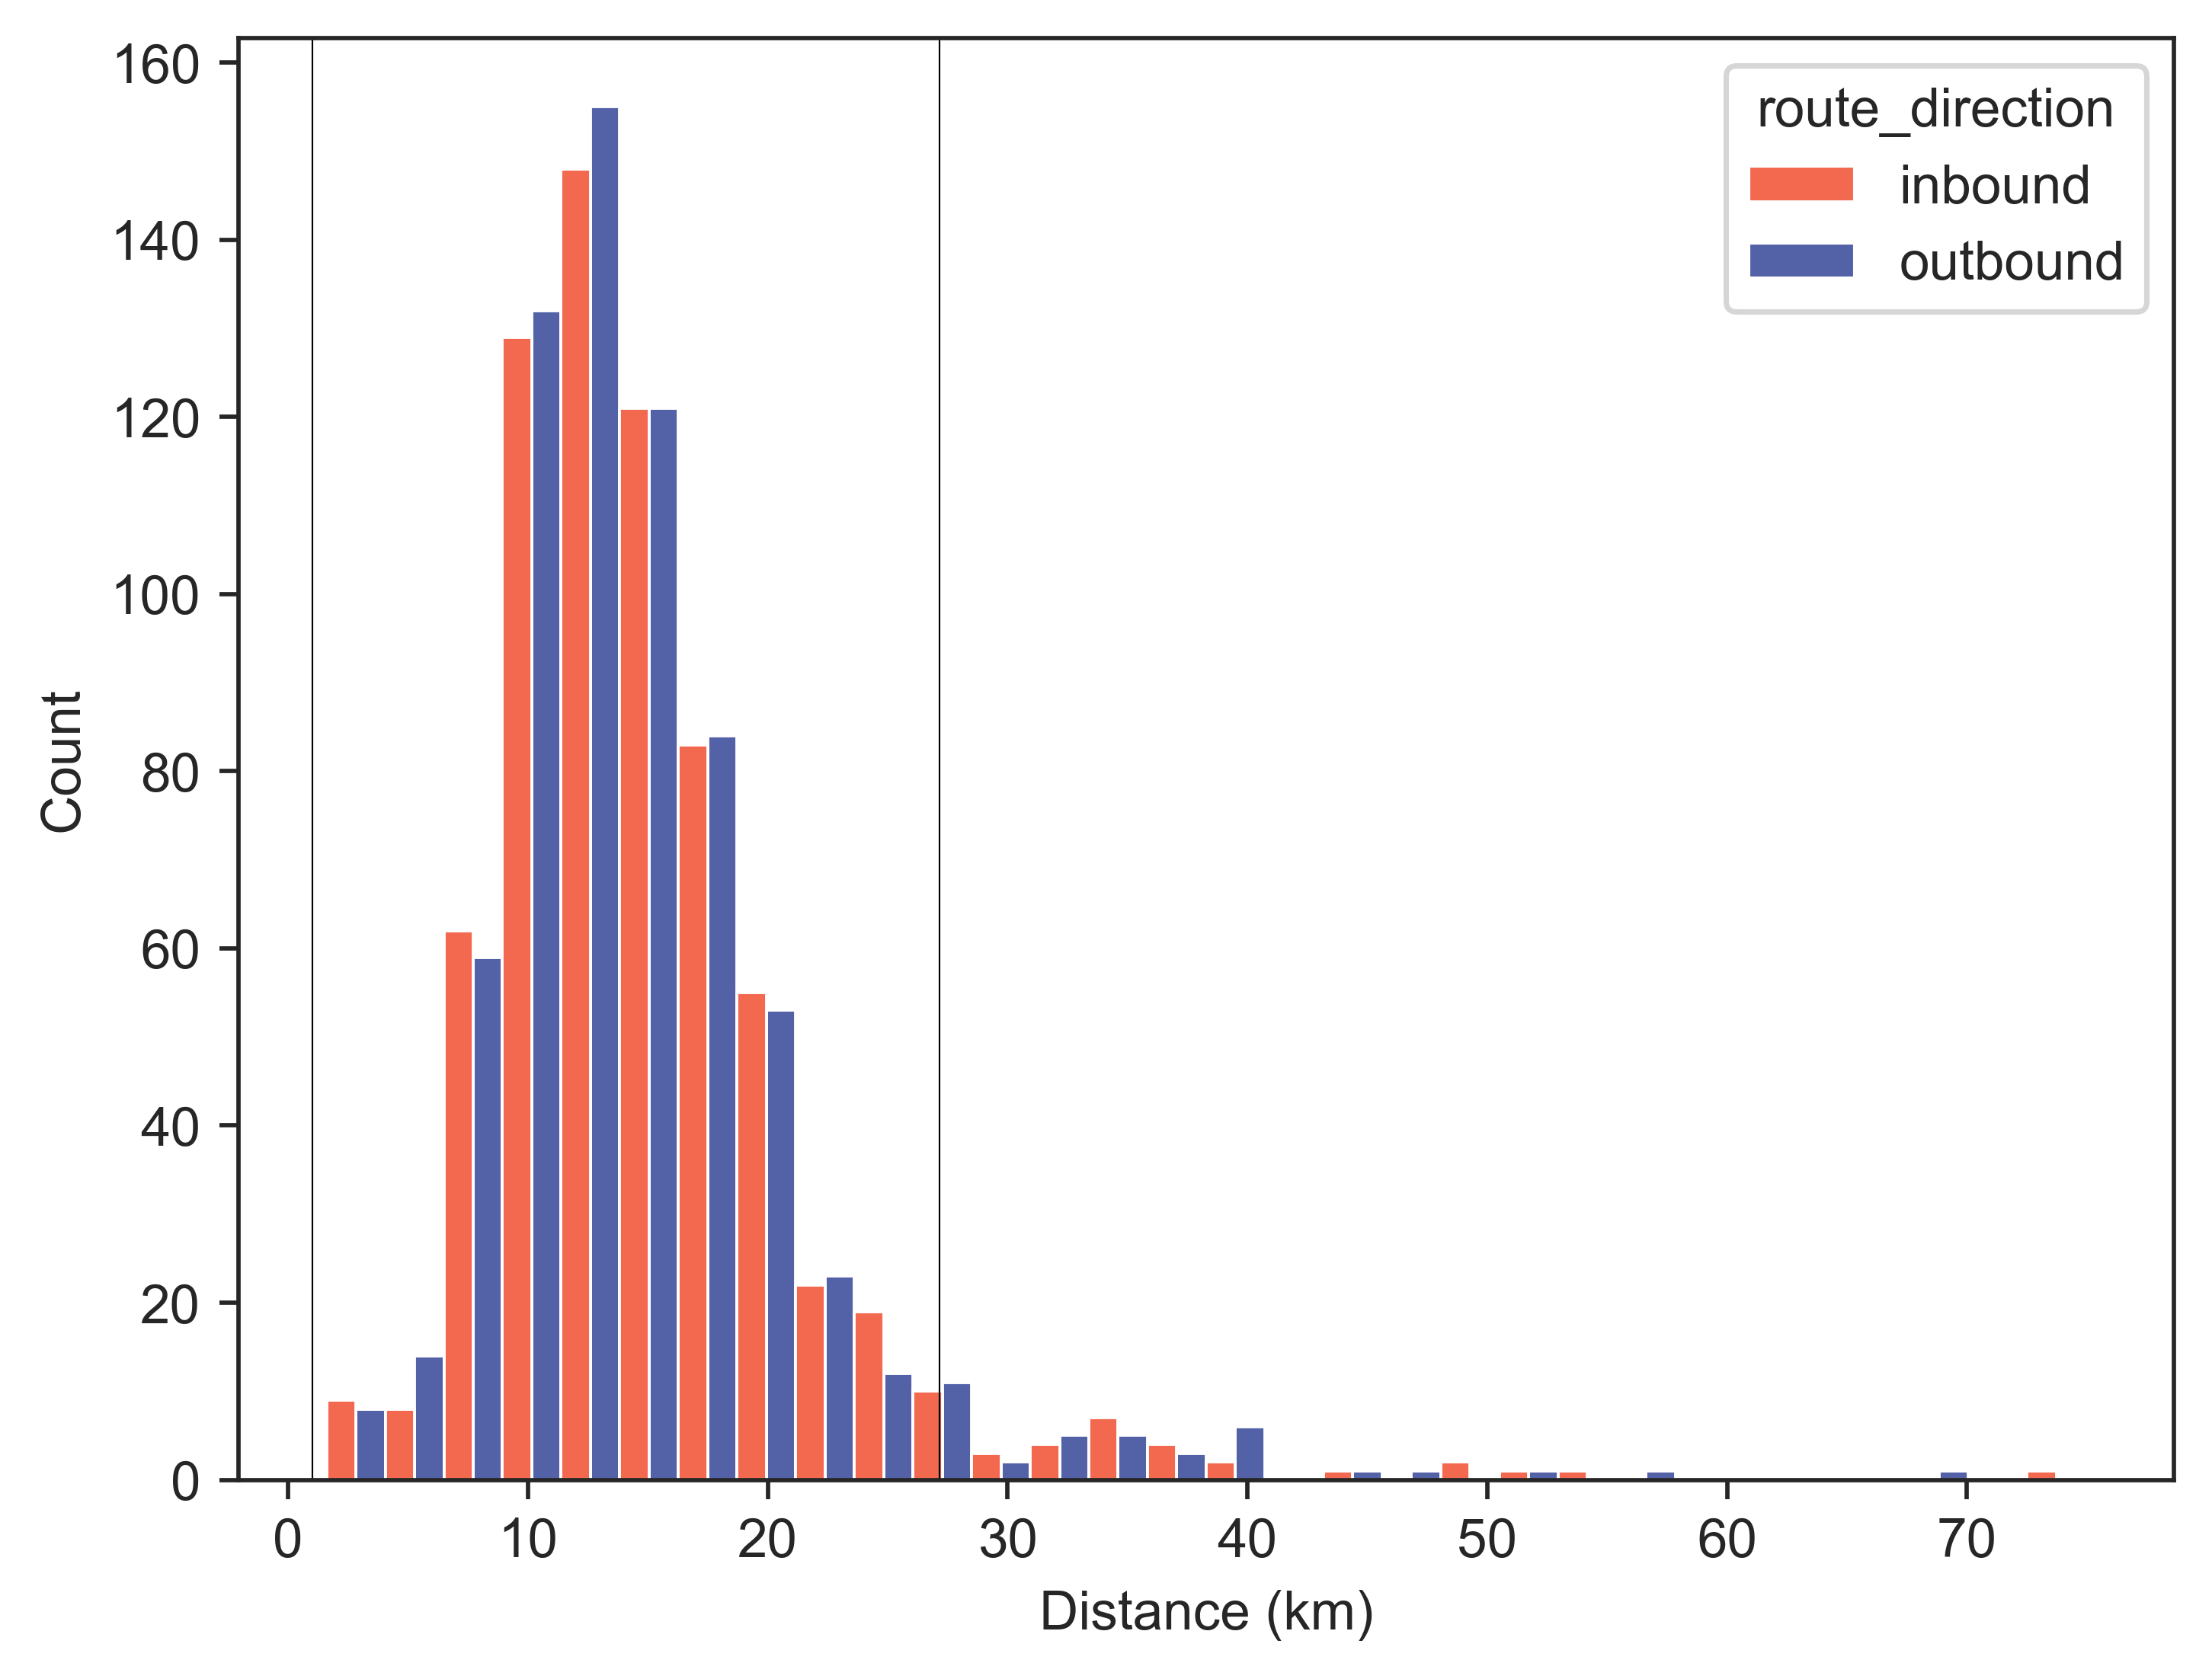

In [102]:
"""Route distance histogram"""
data = bus_routes_df[["route_distance", "route_direction", "route_stop_count"]].copy()
data["route_distance"] = data["route_distance"].div(1000)

Q1 = data["route_distance"].quantile(0.25)
Q3 = data["route_distance"].quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
threshold_l = Q1 - threshold * IQR
threshold_u = Q3 + threshold * IQR


hue_order = direction_palette.keys()
palette = [direction_palette[k][0] for k in hue_order]

ax = sns.histplot(
    data=data,
    x="route_distance",
    hue="route_direction",
    hue_order=hue_order,
    palette=palette,
    bins=30,
    alpha=0.8,
    multiple="dodge",
)
ax.set(xlabel="Distance (km)", ylabel="Count")


ax.axvline(threshold_l, color="black", lw=0.3)
ax.axvline(threshold_u, color="black", lw=0.3)

plt.show()

### Distance and stop points

Plotting route distance against the number of stop points shows a very strong positive correlationg for values around the mean, but very little for outliers on the longer end. 

An interesting grouping of around 10 routes from 10km to 20km shows an even more aggressive linear correlation, though it may be worth checking if these are circlular routes in which case they may be duplicating stops.

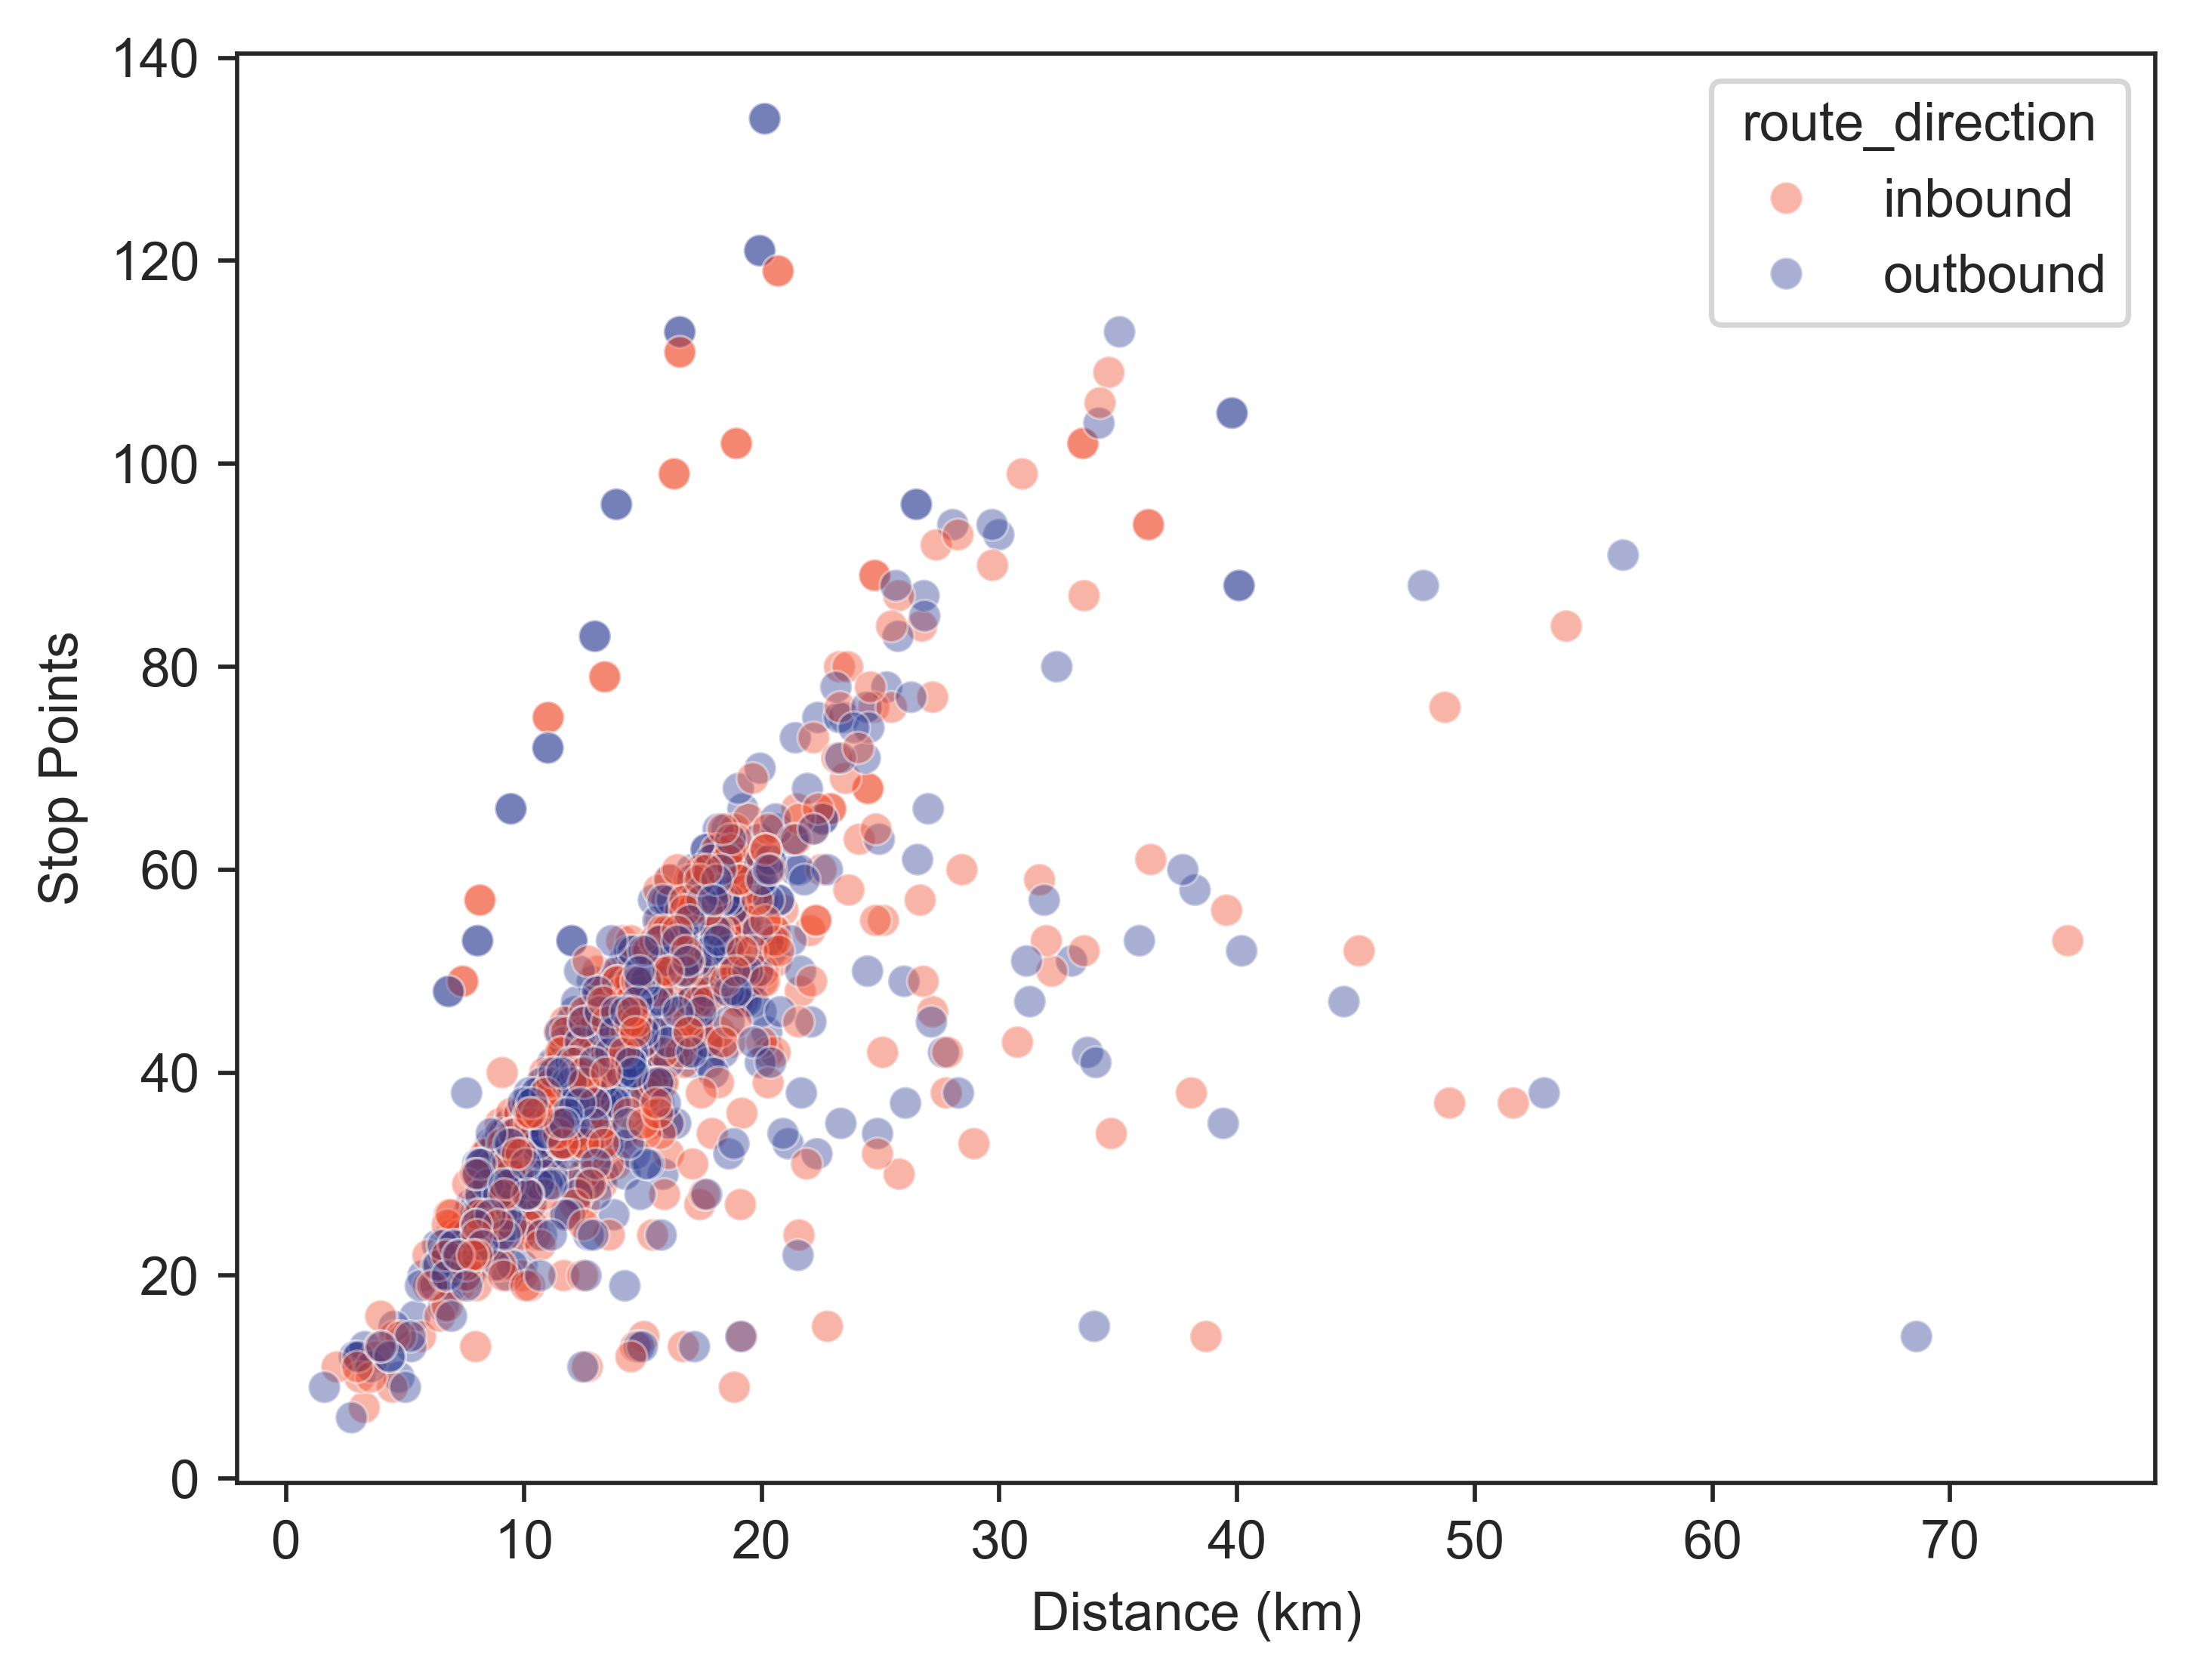

In [103]:
hue_order = direction_palette.keys()
palette = [direction_palette[k][0] for k in hue_order]

ax = sns.scatterplot(
    data=data,
    x="route_distance",
    y="route_stop_count",
    hue="route_direction",
    hue_order=hue_order,
    palette=palette,
    alpha=0.4,
    # multiple="dodge",
)
ax.set(xlabel="Distance (km)", ylabel="Stop Points")

plt.show()

In [104]:
"""Plot one or more routes including bounding box and centroid."""


def get_route_features(
    line_id: str,
    directions: [Direction] = None,
):
    """Create a feature group for the route sequences of the indicated directions."""
    if directions is None:
        directions = [Direction.INBOUND, Direction.OUTBOUND]

    bus_line = (
        bus_routes_df.loc[
            (bus_routes_df["id"] == line_id)
            & (bus_routes_df["route_direction"].isin(directions)),
        ]
        .copy()
        .reset_index()
    )

    # Filter bus routes by line_id and direction
    line_routes = bus_line[["route_direction", "route_line_strings"]]

    # Parse JSON encoded line_strings
    # NOTE: Reverses coordinate order `[lon, lat]` -> `[lat, lon]`
    line_routes["route_line_strings"] = line_routes["route_line_strings"].apply(
        parse_linestrings,
    )

    # Flatten all route coordinates into a single list
    all_points = next(
        itertools.chain.from_iterable(line_routes["route_line_strings"].tolist()),
    )

    # Parse JSON encoded line_strings
    # NOTE: Reverting point order `[lat, lon]` -> `[lon, lat]`
    all_points_geo = LineString([Point([lon, lat]) for lat, lon in all_points])

    # Bounds
    min_lon, min_lat, max_lon, max_lat = all_points_geo.bounds
    sw = [min_lat, min_lon]
    ne = [max_lat, max_lon]
    bounds_center = [(min_lat + max_lat) / 2, (min_lon + max_lon) / 2]

    # Route metrics
    centroid = shapely.centroid(all_points_geo)
    c_lat = centroid.y
    c_lon = centroid.x
    c_v = [[max_lat, c_lon], [min_lat, c_lon]]
    c_h = [[c_lat, max_lon], [c_lat, min_lon]]

    # Routes
    route_polylines = []
    for i, row in line_routes.iterrows():
        color = direction_palette[row["route_direction"]][i]
        route_polylines.append(
            folium.PolyLine(
                row["route_line_strings"],
                color=color,
                weight=2.5,
                opacity=0.6,
            ),
        )
    # Markers
    bl = bus_line.iloc[0].copy()

    line_popup = folium.Popup(
        f"<h4>{bl['name']}</h4><h3>{bl['route_name']}</h3>",
        max_width=300,
        min_width=300,
    )

    tooltip = f"{bl['name']} {bl['route_name']}"

    bounding_box = folium.Rectangle(
        bounds=[sw, ne],
        color="black",
        weight=1,
        fill=True,
        fill_opacity=0,
        popup=line_popup,
        tooltip=tooltip,
    )

    centroid_marker = folium.Circle(
        location=(c_lat, c_lon),
        radius=120,
        color="black",
        weight=1,
    )

    centroid_crosshair = folium.PolyLine(
        [c_v, c_h], color="black", weight=1, opacity=0.6
    )

    route_group = folium.FeatureGroup(bus_line.iloc[0]["id"])

    # Title
    title_html = (
        '<div style="position:absolute;z-index:100000;bottom:4px;left:4px;padding:8px;background-color:rgba(255, 255, 255, 0.6);">'
        f'<h2>{bl["name"]} {bl["route_name"]}</h2>'
        f'<p style="font-family: monospace;">distance: {bl["route_distance"]/1000:.2f}km stop count: {bl["route_stop_count"]}</p>'
        "</div>"
    )

    ## Add to map
    # routes
    for p in route_polylines:
        p.add_to(route_group)

    # markers
    bounding_box.add_to(route_group)
    centroid_marker.add_to(route_group)
    centroid_crosshair.add_to(route_group)

    return {
        "id": line_id,
        "title": title_html,
        "feature_group": route_group,
        "bounds": {"sw": sw, "ne": ne, "center": bounds_center},
    }


def _plot_route_groups(
    route_groups: list[dict],
    title: str | None = None,
) -> folium.Map:
    """Create map with multiple route feature groups."""

    def _point_mean(points: list[tuple[float, float]]) -> tuple[float, float]:
        """Calculate the mean of a list of point tuples."""
        x_m = sum([p[0] for p in points]) / len(points)
        y_m = sum([p[1] for p in points]) / len(points)
        return (x_m, y_m)

    def _geo_min(points: list[tuple[float, float]]) -> tuple(float, float):
        geo = LineString([Point(lon, lat) for lat, lon in points])
        min_lon, min_lat, _, _ = geo.bounds

        return [min_lat, min_lon]

    def _geo_max(points: list[tuple[float, float]]) -> tuple(float, float):
        geo = LineString([Point(lon, lat) for lat, lon in points])
        _, _, max_lon, max_lat = geo.bounds

        return [max_lat, max_lon]

    is_multi = len(route_groups) > 1

    center_m = (
        _point_mean(
            [route_group["bounds"]["center"] for route_group in route_groups],
        )
        if is_multi
        else route_groups[0]["bounds"]["center"]
    )

    sw_min = (
        _geo_min([route_group["bounds"]["sw"] for route_group in route_groups])
        if is_multi
        else route_groups[0]["bounds"]["sw"]
    )
    ne_max = (
        _geo_max([route_group["bounds"]["ne"] for route_group in route_groups])
        if is_multi
        else route_groups[0]["bounds"]["ne"]
    )

    ## Create map
    m = folium.Map(
        location=center_m,
        zoom_start=13,
        tiles="CartoDB Positron",
    )
    # fitting
    m.fit_bounds([sw_min, ne_max])

    ## Add to map
    for route_group in route_groups:
        route_group["feature_group"].add_to(m)

    # title
    if not is_multi:
        m.get_root().html.add_child(folium.Element(route_groups[0]["title"]))
    elif title is not None:
        title_html = (
            '<div style="position:absolute;z-index:100000;bottom:4px;left:4px;padding:8px;background-color:rgba(255, 255, 255, 0.6);">'
            f"{title}"
            "</div>"
        )

        m.get_root().html.add_child(folium.Element(title_html))

    # layer control
    folium.LayerControl().add_to(m)

    return m


def plot_routes(
    line_ids: list[str],
    directions: [Direction] | None = None,
    title: str | None = None,
) -> folium.Map:
    """Plot multiple routes."""
    if directions is None:
        directions = [Direction.INBOUND, Direction.OUTBOUND]

    route_groups = [get_route_features(line_id, directions) for line_id in line_ids]

    return _plot_route_groups(route_groups, title)


# m = plot_routes(["177"])
# m


## Mapping

Even this small sample of the data available from the API gives a wealth of opportunities for geospatial analysis. This small sample only touches on the metrics that could be explored. Hear we see the routes of a single line as well as the bounding box and centroid for the route. The centroid in particular seems an intrigueing metric to explore further, possibly showing areas of habitation vs work if heavily skewed?

In [105]:
"""Plot of the longest and shortest lines."""

title = (
    "<h2 style='padding:2px 0;'>Longest & Shortest Lines</h2>"
    f"<h4>{longest_route['name']} {longest_route['route_name']}</h4>"
    f"<h4>{shortest_route['name']} {shortest_route['route_name']}</h4>"
)
m = plot_routes([longest_route["id"], shortest_route["id"]], title=title)
m


In [106]:
"""Single line plot (101 - Woodbine Place - Beckton Bus Station)"""

m = plot_routes(["101"])
m

In [107]:
import ipywidgets
from IPython.display import HTML, display

out = ipywidgets.Output(layout={"border": "1px solid black"})

line_ids = bus_df["name"].tolist()

w = ipywidgets.Dropdown(
    options=line_ids,
    value=line_ids[0],
    description="Line",
    disabled=False,
)


def on_dropdown_change(change):
    if change["name"] == "value" and (change["new"] != change["old"]):
        out.clear_output()
        with out:
            m = plot_routes(change["new"])
            display(m)


w.observe(on_dropdown_change, names="value")
display(w)

with out:
    m = plot_routes(w.value)
    display(m)

Dropdown(description='Line', options=('1', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109…